# comparing loss functions
## a graphical analysis
> Sammer, Matthias & Leitner, Paul

### Definition, explanation
*A loss function is used to optimize the parameter values in a neural network model. 
Loss functions map a set of parameter values for the network onto a scalar value 
that indicates how well those parameter accomplish the task the network is intended to do.* 

Here we will graphically examine a few of the most common loss functions in more detail, 
in order to gain a more intuitive understanding of the underlying principles in Python

### Preparation, packages, data generation

since data wrangling is not the exact scope of this investigation, we quickly generate some data from sklearn

In [1]:
from sklearn.datasets import make_regression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# generate a large amount of data, unscaled - 20% noise in order to challenge the model
X, y = make_regression(n_samples=1000,
                       n_features=20,
                       noise=.1,
                       random_state=1)

# this data is of course unscaled --> preprocess the data
# usually this would include imputation, EDA, encoding - out of scope here
pipe_x = Pipeline(steps=[('scaling', StandardScaler())])
pipe_y = Pipeline(steps=[('scaling', StandardScaler())])

X_processed = pipe_x.fit_transform(X)
y_processed = pipe_y.fit_transform(y.reshape(-1, 1))

train_X, test_X, train_y, test_y = train_test_split(X_processed, y_processed, 
                                                    random_state=1,
                                                    test_size=.1)

### model generation

we quickly generate a sequential NN - as a simple demonstration for graphing the loss

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.initializers import he_uniform


# simple sequential model, dense layer, relu activation
sequential_model = Sequential()

bias_initializer = he_uniform(seed=42)
sequential_model.add(Dense(25, 
                           input_dim=20, 
                           activation='relu',
                           kernel_initializer=bias_initializer))
sequential_model.add(Dense(1, 
                           activation='linear'))

# using a simple gradient descent optimizer
opt = SGD(lr=0.01, 
          momentum=0.9)

sequential_model.compile(loss='mean_squared_error', 
                         optimizer=opt)

Using TensorFlow backend.


now that we initialized the model, we train it with history and graph the (MSE) loss


### Graphing Regression Loss - Mean Squared/Absolute Error

Train MSE: 0.0012, Test MSE: 0.0018 



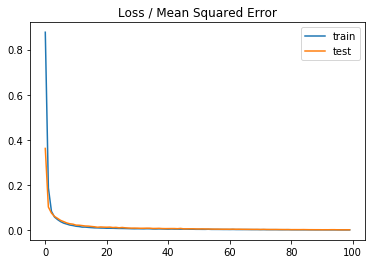

In [3]:
import matplotlib.pyplot as plt


# train the model on our test data in 100 epochs
loss_history = sequential_model.fit(train_X, train_y, 
                                    validation_data=(test_X, test_y), 
                                    epochs=100, 
                                    verbose=0)

# get the final train and test MSE of the model
train_mse = sequential_model.evaluate(train_X, train_y, 
                                      verbose=0)

test_mse = sequential_model.evaluate(test_X, test_y, 
                                     verbose=0)

print(f'Train MSE: {round(train_mse, 4)}, Test MSE: {round(test_mse, 4)} \n')

# plot loss over the training epochs
plt.title('Loss / Mean Squared Error')
plt.plot(loss_history.history['loss'], label='train')
plt.plot(loss_history.history['val_loss'], label='test')
plt.legend()
plt.show()


MSE converges rather quickly and smoothly here (i.e. it is well suited to this problem)

sequential network mean absolute error loss - Train MSE: 0.0854995459318161, Test MSE: 0.08567120254039765


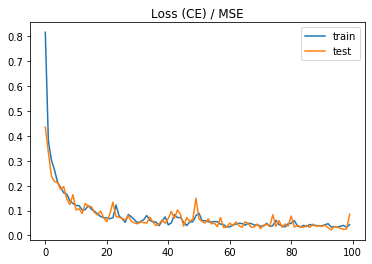

In [4]:
mae = Sequential()
mae.add(Dense(25,
                           input_dim=20,
                           activation='relu',
                           kernel_initializer=bias_initializer))
mae.add(Dense(1,
                           activation='linear'))
mae.compile(loss='mean_absolute_error',
            optimizer=opt)

mae_loss_history = mae.fit(train_X, train_y,
                           validation_data=(test_X, test_y),
                           epochs=100,
                           verbose=0)
mae_train_mse = mae.evaluate(train_X, train_y,
                             verbose=0)
mae_test_mse = mae.evaluate(test_X, test_y, 
                            verbose=0)

print(f'sequential network mean absolute error loss - Train MSE: {mae_train_mse}, Test MSE: {mae_test_mse}')

# plot loss over training 
plt.title('Loss (CE) / MSE')
plt.plot(mae_loss_history.history['loss'], label='train')
plt.plot(mae_loss_history.history['val_loss'], label='test')
plt.legend()
plt.show()

as we can see, the network does not converge as far in 100 epochs, which is probably due to the fact 
that mean absolute error loss does not punish outliers as strongly as MSE - and we are using scaled data 
from an automatically generated normal distribution (i.e. no outliers).

MAE might be more useful to a problem where we are working with unscaled data, containing outliers, which we do not
want to suppress using a robust scaler. 

### Graphing Loss functions for Classification - Binary Cross Entropy


for this demonstration, we use the wisconsin breast cancer set from sklearn to provide a more applicable example.
Loading and processing the data:

In [13]:
from sklearn.datasets import load_breast_cancer
from keras import backend as K


# unfortunately, recall was removed as a metric from keras so we had to write our own
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

bc_X, bc_y = load_breast_cancer(return_X_y=True)

bc_train_X, bc_test_X, bc_train_y, bc_test_y = train_test_split(bc_X, bc_y,
                                                                random_state=1,
                                                                test_size=.2)

pipe_bc_x = Pipeline(steps=[('scale', StandardScaler())])
bc_train_X_processed = pipe_bc_x.fit_transform(bc_train_X)


then we create a basic NN

In [15]:
bias_initializer_bc = he_uniform(seed=1)

bc_nn = Sequential()
bc_nn.add(Dense(50,
                input_dim=30,
                activation='relu',
                kernel_initializer=bias_initializer_bc))
# since the output in this case is a binary classificaiton, we use a sigmoid activation function for the output layer
bc_nn.add(Dense(1,
                activation='sigmoid'))
bc_optimizer = SGD(lr=0.01,
                   momentum=0.9)

# since the cost of false negative is significantly higher here
# we use recall as an additional (arguably more important) metric
bc_nn.compile(optimizer=bc_optimizer, 
              loss='binary_crossentropy', 
              metrics=['accuracy', recall_m])

we fit our network on the training data and graph the loss over the epochs

Train recall: 1.0, Test recall: 1.0
Train accuracy: 0.6263736486434937, Test accuracy: 0.6315789222717285


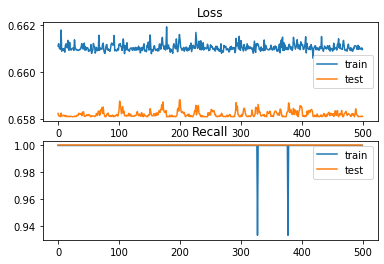

In [34]:
history = bc_nn.fit(bc_train_X, bc_train_y,
                    validation_data=(bc_test_X, bc_test_y),
                    epochs=500, 
                    verbose=0)

# get the metrics for the NN
# the first variable returned is the scalar loss (see here: https://keras.io/models/model/#evaluate)
# which we are not interested in here
_, train_acc, train_recall = bc_nn.evaluate(bc_train_X, bc_train_y, 
                                            verbose=0)

_, test_acc, test_recall = bc_nn.evaluate(bc_test_X, bc_test_y, 
                                          verbose=0)

print(f'Train recall: {train_recall}, Test recall: {test_recall}')
print(f'Train accuracy: {train_acc}, Test accuracy: {test_acc}')
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Recall')
plt.plot(history.history['recall_m'], label='train')
plt.plot(history.history['val_recall_m'], label='test')
plt.legend()
plt.show()

Binary cross entropy does not quite seem suited to this problem - probably due to the small size of the dataset...

We will try the same Problem using hinge loss, this may perform better 
due to the fact that hinge loss punishes errors more strongly, which are further away from the correct label

### Graphing Hinge Loss